In [20]:
%matplotlib inline
import numpy as np
from tqdm import trange
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt

In [21]:
def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]


### Lets just make it in pytorch for comparision sake !

In [22]:
#Model making
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.set_printoptions(sci_mode=False)
class BobNet(torch.nn.Module):
  def __init__(self):
    super(BobNet, self).__init__()
    self.l1 = nn.Linear(784, 128, bias=False)
    self.l2 = nn.Linear(128, 10, bias=False)
    self.sm = nn.LogSoftmax(dim=1)
  def forward(self, x):
    x = F.relu(self.l1(x))
    x = self.l2(x)
    x = self.sm(x)
    return x


### Training it in pytorch

loss %.2f accuracy %.2f: 100%|██████████| 1000/1000 [00:03<00:00, 257.77it/s]


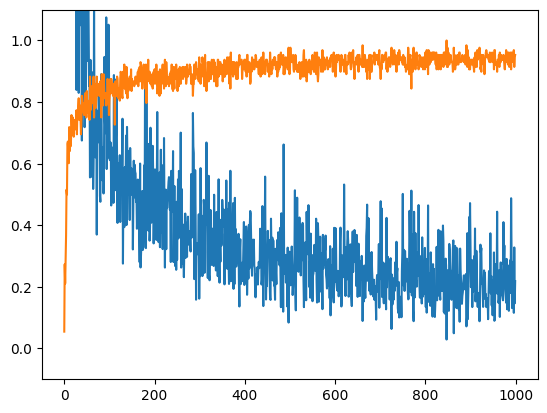

In [23]:
model = BobNet()

"""
    you could torch.no_grad() it
    model.l1.weight.copy_(torch.tensor(layer_init(784, 128).T))
    model.l2.weight.copy_(torch.tensor(layer_init(128, 10).T))
"""

loss_function = nn.NLLLoss(reduction='none')
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
BS = 128
losses, accuracies = [], []
for i in (t := trange(1000)):
  samp = np.random.randint(0, X_train.shape[0], size=(BS))
  X = torch.tensor(X_train[samp].reshape((-1, 28*28))).float()
  Y = torch.tensor(Y_train[samp]).long()
  model.zero_grad()
  out = model(X)
  cat = torch.argmax(out, dim=1)
  accuracy = (cat == Y).float().mean()
  loss = loss_function(out, Y)
  loss = loss.mean()
  loss.backward()
  optim.step()
  loss, accuracy = loss.item(), accuracy.item()
  losses.append(loss)
  accuracies.append(accuracy)
  t.set_description("loss %.2f accuracy %.2f", (loss, accuracy))
plt.ylim(-0.1, 1.1)
plot(losses)
plot(accuracies)
  


In [25]:
#EVAL TIME
Y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim=1).numpy()
(Y_test == Y_test_preds).mean()

0.9345

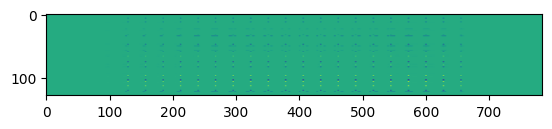

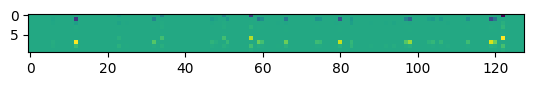

In [27]:
#GRADIENT COMPUTING IN PyTorch

samp = [0,1,2,3]
model.zero_grad()
out = model(torch.tensor(X_test[samp].reshape((-1, 28*28))).float())
out.retain_grad()
loss = loss_function(out, torch.tensor(Y_test[samp]).long()).mean()
loss.retain_grad()
loss.backward()
imshow(model.l1.weight.grad)
figure()
imshow(model.l2.weight.grad)

In [33]:
#Get weights from pytorch

l1 = model.l1.weight.detach().numpy().T
l2 = model.l2.weight.detach().numpy().T

#numpy forward

def forward(x):
    x = x.dot(l1)
    x = np.maximum(x,0)
    x = x.dot(l2)
    return x

def numpy_eval():
    Y_test_preds_out = forward(X_test.reshape((-1, 28*28)))
    Y_test_preds = np.argmax(Y_test_preds_out, axis = 1)
    return  (Y_test == Y_test_preds).mean()

numpy_eval()

0.9345

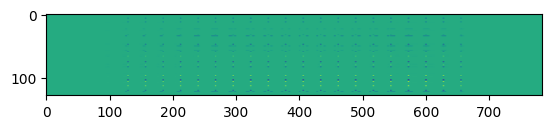

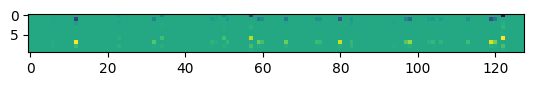

In [38]:
#Numpy forward AND Backward pass

def logsumexp(x):
    c = x.max(axis = 1)
    return c + np.log(np.exp(x-c.reshape((-1,1))).sum(axis =1))

def forward_backward(x ,y):
    #Training
    out = np.zeros((len(y),10), np.float32)
    out[range(out.shape[0]),y] = 1
    
    #Forward pass
    x_l1 = x.dot(l1)
    x_relu = np.maximum(x_l1,0)
    x_l2 = x_relu.dot(l2)
    x_lsm = x_l2 - logsumexp(x_l2).reshape((-1,1))
    x_loss = (-out * x_lsm).mean(axis = 1)
    
    
    d_out = -out / len(y)
    dx_lsm = d_out - np.exp(x_lsm)*d_out.sum(axis=1).reshape((-1, 1))

  # derivative of l2
    d_l2 = x_relu.T.dot(dx_lsm)
    dx_relu = dx_lsm.dot(l2.T)

  # derivative of relu
    dx_l1 = (x_relu > 0).astype(np.float32) * dx_relu

  # derivative of l1
    d_l1 = x.T.dot(dx_l1)
  
    return x_loss, x_l2, d_l1, d_l2

samp = [0,1,2,3]
x_loss, x_l2, d_l1, d_l2 = forward_backward(X_test[samp].reshape((-1, 28*28)), Y_test[samp])

imshow(d_l1.T)
figure()
imshow(d_l2.T)
    
    
    

loss 0.01 accuracy 0.98: 100%|██████████| 1000/1000 [00:02<00:00, 337.19it/s]


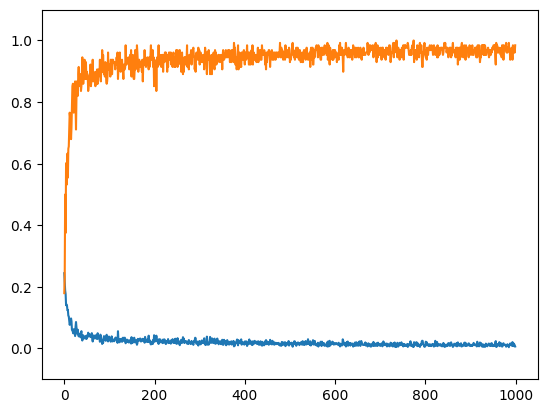

In [39]:
#NUMPY TRAINING TIME


def layer_init(m,h):
    #Gaussian
    #ret = np.random.randn(m,h)/np.sqet(m*h)
    
    #We will use Uniform
    ret = np.random.uniform(-1.,1.,size=(m,h))/ np.sqrt(m*h)
    return ret.astype(np.float32)


np.random.seed(1337)
l1 = layer_init(784,128)
l2 = layer_init(128,10)

lr = 0.001
BS = 128

losses, accuracies = [], []
for i in (t := trange(1000)):
    samp = np.random.randint(0, X_train.shape[0], size=(BS))
    X = X_train[samp].reshape((-1, 28*28))
    Y = Y_train[samp]
    x_loss, x_l2, d_l1, d_l2 = forward_backward(X, Y)
  
    cat = np.argmax(x_l2, axis=1)
    accuracy = (cat == Y).mean()
  
  # SGD
    l1 = l1 - lr*d_l1
    l2 = l2 - lr*d_l2
  
    loss = x_loss.mean()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
  
plt.ylim(-0.1, 1.1)
plot(losses)
plot(accuracies)

In [40]:
numpy_eval()

0.9637

### Based on the above results , NUMPY TRAINED BETTER THAN Pytorch??!!!

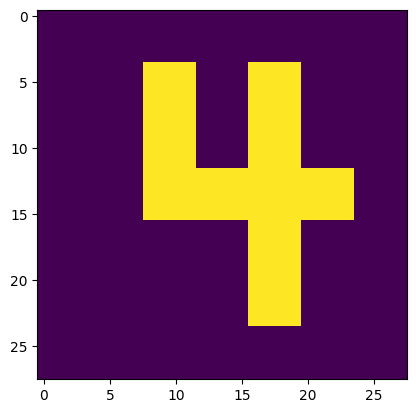

In [41]:
#Test it !!

m = [[0,0,0,0,0,0,0],
     [0,0,1,0,1,0,0],
     [0,0,1,0,1,0,0],
     [0,0,1,1,1,1,0],
     [0,0,0,0,1,0,0],
     [0,0,0,0,1,0,0],
     [0,0,0,0,0,0,0]]
m = np.concatenate([np.concatenate([[x] * 4 for x in y] * 4) for y in m])
/
imshow(m.reshape(28,28))

In [42]:
# can It recognize it 

x = m.reshape(1,-1).dot(l1)
x = np.maximum(x,0)
x = x.dot(l2)
np.argmax(x)

4

In [43]:
## YAYY